# Programmet har til formål at få geocoded apoteker og apoteksåbninger. Dette skal bruges til at skabe konkurrence og forbruger parametre. 

In [154]:
import numpy             as np
import matplotlib.pyplot as plt           #We use it for construction of graphs, both 3D and 2D

import pandas as pd

import json
import os
import requests

# spatial stuff
import geopandas as gpd
import fiona
import folium
import shapely
from descartes import PolygonPatch
from tqdm import tqdm



Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
current_path = os.getcwd()
current_path

'C:\\Users\\Nicklas Lindegaard\\Desktop\\Speciale\\Python\\thesis_2020 - midl'

Importering af Excel oversigt over apoteker

In [3]:
url = 'https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/APOTEK_20200109.csv'
exceldata = pd.read_csv(url , error_bad_lines=False)
exceldata = exceldata.dropna(subset=['Adresse', 'PostNr'])
exceldata


,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,Region
0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,1084.0
1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,1084.0
2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,1084.0
3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,1084.0
4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,1084.0
...,...,...,...,...,...,...,...,...,...,...
790,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,1082.0
791,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,1082.0
792,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,1081.0
793,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,1083.0


In [4]:
exceldata_adress = exceldata["Adresse"]
exceldata_postal = exceldata["PostNr"].apply(int)
exceldata["Adresse_v2"] = exceldata["Adresse"] + ', ' + exceldata_postal.astype(str) + ' Denmark'


exceldata_addres_list = list(exceldata["Adresse_v2"])
exceldata

,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,Region,Adresse_v2
0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,1084.0,"Bytorvet 5, 2620 Denmark"
1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,1084.0,"Allerød Stationsvej 9, 3450 Denmark"
2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark"
3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark"
4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,1084.0,"Strandlodsvej 41, 2300 Denmark"
...,...,...,...,...,...,...,...,...,...,...,...
790,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,1082.0,"Viby Ringvej 10, ST. 26, 8260 Denmark"
791,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,1082.0,"Haslevej 17, 8230 Denmark"
792,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,1081.0,"Søndergade 34, 9600 Denmark"
793,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,1083.0,"Bredgade 25, 5560 Denmark"


Geocoding


In [5]:
print(type(exceldata_addres_list[0]))

df = gpd.tools.geocode(exceldata_addres_list[700])
df

<class 'str'>


,geometry,address
0,POINT (10.20717 56.15792),"Immervad 2, 8000 Århus C, Denmark"


Note: you may need to restart the kernel to use updated packages.


In [6]:
from opencage.geocoder import OpenCageGeocode

key = "5ce774970ad843b1bfebabd2ac5c098f"
geocoder = OpenCageGeocode(key)

url = 'https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/APOTEK_20200109.csv'
exceldata = pd.read_csv(url , error_bad_lines=False)
exceldata = exceldata.dropna(subset=['Adresse', 'PostNr'])

exceldata_adress = exceldata["Adresse"]
exceldata_postal = exceldata["PostNr"].apply(int)
exceldata["Adresse_v2"] = exceldata["Adresse"] + ', ' + exceldata_postal.astype(str) + ' Denmark'


exceldata_addres_list = list(exceldata["Adresse_v2"])


In [8]:
latitudes = []
longitudes = []

for address in exceldata_addres_list:
	result = geocoder.geocode(address, no_annotations="1")

	if result and len(result):
		longitude = result[0]['geometry']['lng']
		latitude = result[0]['geometry']['lat']
	else:
		longitude = "N/A"
		latitude = "N/A"

	latitudes.append(latitude)
	longitudes.append(longitude)

In [7]:
from datetime import datetime
type(exceldata["Startdato"][0])

str

In [21]:
exceldata

,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,Region,Adresse_v2,latitudes,longitudes,dato,year,dummy,Stdato
0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,1084.0,"Bytorvet 5, 2620 Denmark",55.656514,12.353695,1966-01-01,1966.0,2008.0,1966-01-01
1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,1084.0,"Allerød Stationsvej 9, 3450 Denmark",55.871124,12.355782,NaT,NaN,2008.0,NaT
2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,2016-05-01,2016.0,2016.0,2016-05-01
3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,1898-01-01,1898.0,2008.0,1898-01-01
4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,1084.0,"Strandlodsvej 41, 2300 Denmark",55.664181,12.622773,2015-09-21,2015.0,2015.0,2015-09-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,1082.0,"Viby Ringvej 10, ST. 26, 8260 Denmark",56.166300,10.198700,1933-01-01,1933.0,2008.0,1933-01-01
791,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,1082.0,"Haslevej 17, 8230 Denmark",56.156458,10.164773,1936-01-01,1936.0,2008.0,1936-01-01
792,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,1081.0,"Søndergade 34, 9600 Denmark",56.802114,9.519024,1905-01-01,1905.0,2008.0,1905-01-01
793,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,1083.0,"Bredgade 25, 5560 Denmark",55.381312,10.049612,1859-01-01,1859.0,2008.0,1859-01-01


In [26]:
exceldata["latitudes"] = latitudes
exceldata["longitudes"] = longitudes

exceldata_startdato_list = list(exceldata["Startdato"])

#exceldata["dato"]      = datetime.fromisoformat(exceldata_startdato_list[:-1])
exceldata["Stdato"] = pd.to_datetime(exceldata['Startdato'] , errors='coerce')
exceldata["Sldato"] = pd.to_datetime(exceldata['Slutdato'] , errors='coerce')
exceldata["Styear"] = pd.DatetimeIndex(exceldata['Stdato']).year
exceldata["Slyear"] = pd.DatetimeIndex(exceldata['Sldato']).year

exceldata

,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,Region,Adresse_v2,latitudes,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear
0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,1084.0,"Bytorvet 5, 2620 Denmark",55.656514,12.353695,1966-01-01,1966.0,2008.0,1966-01-01,NaT,1966.0,NaN
1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,1084.0,"Allerød Stationsvej 9, 3450 Denmark",55.871124,12.355782,NaT,NaN,2008.0,NaT,NaT,NaN,NaN
2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,2016-05-01,2016.0,2016.0,2016-05-01,NaT,2016.0,NaN
3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,1898-01-01,1898.0,2008.0,1898-01-01,2016-05-01,1898.0,2016.0
4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,1084.0,"Strandlodsvej 41, 2300 Denmark",55.664181,12.622773,2015-09-21,2015.0,2015.0,2015-09-21,NaT,2015.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,1082.0,"Viby Ringvej 10, ST. 26, 8260 Denmark",56.166300,10.198700,1933-01-01,1933.0,2008.0,1933-01-01,NaT,1933.0,NaN
791,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,1082.0,"Haslevej 17, 8230 Denmark",56.156458,10.164773,1936-01-01,1936.0,2008.0,1936-01-01,NaT,1936.0,NaN
792,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,1081.0,"Søndergade 34, 9600 Denmark",56.802114,9.519024,1905-01-01,1905.0,2008.0,1905-01-01,NaT,1905.0,NaN
793,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,1083.0,"Bredgade 25, 5560 Denmark",55.381312,10.049612,1859-01-01,1859.0,2008.0,1859-01-01,2008-12-31,1859.0,2008.0


In [27]:
exceldata["dummy"] = exceldata["Styear"].where(exceldata["year"] > 2008, 2008)
#for i in range(2009,2010):
#    exceldata["dummy"] = exceldata["year"].where(exceldata["year"] == i, i)

#exceldata["dummy"] = exceldata["year"].where(exceldata["year"] == 2009, 2009)
exceldata

,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,Region,Adresse_v2,latitudes,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear
0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,1084.0,"Bytorvet 5, 2620 Denmark",55.656514,12.353695,1966-01-01,1966.0,2008.0,1966-01-01,NaT,1966.0,NaN
1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,1084.0,"Allerød Stationsvej 9, 3450 Denmark",55.871124,12.355782,NaT,NaN,2008.0,NaT,NaT,NaN,NaN
2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,2016-05-01,2016.0,2016.0,2016-05-01,NaT,2016.0,NaN
3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,1084.0,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,1898-01-01,1898.0,2008.0,1898-01-01,2016-05-01,1898.0,2016.0
4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,1084.0,"Strandlodsvej 41, 2300 Denmark",55.664181,12.622773,2015-09-21,2015.0,2015.0,2015-09-21,NaT,2015.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,1082.0,"Viby Ringvej 10, ST. 26, 8260 Denmark",56.166300,10.198700,1933-01-01,1933.0,2008.0,1933-01-01,NaT,1933.0,NaN
791,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,1082.0,"Haslevej 17, 8230 Denmark",56.156458,10.164773,1936-01-01,1936.0,2008.0,1936-01-01,NaT,1936.0,NaN
792,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,1081.0,"Søndergade 34, 9600 Denmark",56.802114,9.519024,1905-01-01,1905.0,2008.0,1905-01-01,NaT,1905.0,NaN
793,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,1083.0,"Bredgade 25, 5560 Denmark",55.381312,10.049612,1859-01-01,1859.0,2008.0,1859-01-01,2008-12-31,1859.0,2008.0


In [28]:
df=exceldata.reset_index(drop=True)
df
df.to_csv("Apoteker_Geocoded.csv")

In [81]:
import math
exceldata2.Slyear.isnull()


0       True
1       True
2       True
3      False
4       True
       ...  
708     True
709     True
710     True
711    False
712     True
Name: Slyear, Length: 713, dtype: bool

In [86]:
exceldata2 = pd.read_csv(r"C:\Users\Nicklas Lindegaard\Desktop\Speciale\Python\thesis_2020 - midl\Apoteker_Geocoded.csv")
exceldata2["Slyear"] = exceldata2["Slyear"].apply(float) 
exceldata_v2 = exceldata2[(exceldata2.Slyear>2007) | (exceldata2.Slyear.isnull()) ]
exceldata_v2
#df_2008 =  exceldata[(exceldata["dummy"]  == '2008.0')]

,Unnamed: 0,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,...,Adresse_v2,latitudes,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear
0,0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,...,"Bytorvet 5, 2620 Denmark",55.656514,12.353695,1966-01-01,1966.0,2008.0,1966-01-01,NaN,1966.0,NaN
1,1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,...,"Allerød Stationsvej 9, 3450 Denmark",55.871124,12.355782,NaN,NaN,2008.0,NaN,NaN,NaN,NaN
2,2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,...,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,2016-05-01,2016.0,2016.0,2016-05-01,NaN,2016.0,NaN
3,3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,...,"Kirkegade 13, 3770 Denmark",55.277123,14.802304,1898-01-01,1898.0,2008.0,1898-01-01,2016-05-01,1898.0,2016.0
4,4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,...,"Strandlodsvej 41, 2300 Denmark",55.664181,12.622773,2015-09-21,2015.0,2015.0,2015-09-21,NaN,2015.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,708,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,...,"Viby Ringvej 10, ST. 26, 8260 Denmark",56.166300,10.198700,1933-01-01,1933.0,2008.0,1933-01-01,NaN,1933.0,NaN
709,709,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,...,"Haslevej 17, 8230 Denmark",56.156458,10.164773,1936-01-01,1936.0,2008.0,1936-01-01,NaN,1936.0,NaN
710,710,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,...,"Søndergade 34, 9600 Denmark",56.802114,9.519024,1905-01-01,1905.0,2008.0,1905-01-01,NaN,1905.0,NaN
711,711,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,...,"Bredgade 25, 5560 Denmark",55.381312,10.049612,1859-01-01,1859.0,2008.0,1859-01-01,2008-12-31,1859.0,2008.0


In [89]:
from tqdm import tqdm
frames_year = {}
for i in range(2008,2021):
    frames_year[str(i)] = exceldata_v2[(exceldata_v2['dummy']  == i)]  # use globals() to store the vars in the global stack


map1 = folium.Map(
    location=[55.656514 , 	12.353695],
    tiles='cartodbpositron',
    zoom_start=12,
)
frames_year['2008'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='blue',).add_to(map1), axis=1)
frames_year['2009'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='red',).add_to(map1), axis=1)
frames_year['2010'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='green',).add_to(map1), axis=1)
frames_year['2011'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='black',).add_to(map1), axis=1)
frames_year['2012'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='cloud',).add_to(map1), axis=1)
frames_year['2013'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='orange',).add_to(map1), axis=1)
frames_year['2014'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='yellow',).add_to(map1), axis=1)
frames_year['2015'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='purple',).add_to(map1), axis=1)
frames_year['2016'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='lightred',).add_to(map1), axis=1)
frames_year['2017'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='lightgreen',).add_to(map1), axis=1)
frames_year['2018'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='gray',).add_to(map1), axis=1)
frames_year['2019'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='pink',).add_to(map1), axis=1)
frames_year['2020'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='lime',).add_to(map1), axis=1)
  
map1

In [90]:
len(frames_year["2016"])+len(frames_year["2017"])+len(frames_year["2018"])+len(frames_year["2019"])

147

In [91]:
len(frames_year["2008"])

442

In [148]:
frames_map2 = {}
frames_map2['2008'] = exceldata_v2[(exceldata_v2['dummy']  == 2008)]
frames_map2['2008>'] = exceldata_v2[(exceldata_v2['dummy']  > 2008)]

map2 = folium.Map(
    location=[55.656514 , 	12.353695],
    tiles='cartodbpositron',
    zoom_start=12,
)

frames_map2['2008'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='blue',).add_to(map2), axis=1)
frames_map2['2008>'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='red',).add_to(map2), axis=1)

map2
#exceldata["dummy_2"] = exceldata["Styear"].where(exceldata["Styear"] > 2008, 2008)

In [149]:
frames_map3 = {}
frames_map3['2008'] = exceldata_v2[(exceldata_v2['dummy']  == 2008) & (exceldata_v2['TypeID'] != 8)]
frames_map3['2008>'] = exceldata_v2[(exceldata_v2['dummy']  > 2008) & (exceldata_v2['TypeID'] != 8)]

map3 = folium.Map(
    location=[55.656514 , 	12.353695],
    tiles='cartodbpositron',
    zoom_start=12,
)

frames_map3['2008'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='blue',).add_to(map3), axis=1)
frames_map3['2008>'].apply(lambda row:folium.CircleMarker(location=[row["latitudes"], row["longitudes"]],radius=1,color='red',).add_to(map3), axis=1)

map3

# Laver en funktion som har til formål at undersøge hvilket apotek der er tættest på det udvalgte. 

Til at starte med laver jeg en geodataframe, som indeholder de punkter fra overstående koordinater. 

In [234]:
gdf = gpd.GeoDataFrame(exceldata_v2, geometry=gpd.points_from_xy(exceldata_v2.longitudes, exceldata_v2.latitudes))
gdf.to_csv("Main_data_with_geodat.csv")
gdf

,Unnamed: 0,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,...,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear,geometry,test
0,0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,165.0,...,12.353695,1966-01-01,1966.0,2008.0,1966-01-01,NaN,1966.0,NaN,POINT (12.35370 55.65651),0.000000
1,1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,201.0,...,12.355782,NaN,NaN,2008.0,NaN,NaN,NaN,NaN,POINT (12.35578 55.87112),0.214620
2,2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,400.0,...,14.802304,2016-05-01,2016.0,2016.0,2016-05-01,NaN,2016.0,NaN,POINT (14.80230 55.27712),2.477826
3,3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,400.0,...,14.802304,1898-01-01,1898.0,2008.0,1898-01-01,2016-05-01,1898.0,2016.0,POINT (14.80230 55.27712),2.477826
4,4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,101.0,...,12.622773,2015-09-21,2015.0,2015.0,2015-09-21,NaN,2015.0,NaN,POINT (12.62277 55.66418),0.269187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,708,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,751.0,...,10.198700,1933-01-01,1933.0,2008.0,1933-01-01,NaN,1933.0,NaN,POINT (10.19870 56.16630),2.214472
709,709,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,751.0,...,10.164773,1936-01-01,1936.0,2008.0,1936-01-01,NaN,1936.0,NaN,POINT (10.16477 56.15646),2.245289
710,710,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,820.0,...,9.519024,1905-01-01,1905.0,2008.0,1905-01-01,NaN,1905.0,NaN,POINT (9.51902 56.80211),3.057411
711,711,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,420.0,...,10.049612,1859-01-01,1859.0,2008.0,1859-01-01,2008-12-31,1859.0,2008.0,POINT (10.04961 55.38131),2.320460


In [ ]:



from shapely.ops import nearest_points
# unary union of the gpd2 geomtries 
exceldata_v3 = exceldata_v2.geometry.unary_union
def near(point, pts=exceldata_v3):
     # find the nearest point and return the corresponding Place value
     nearest = exceldata_v2.geometry == nearest_points(point, pts)[1]
     return gpd2[nearest].Place.get_values()[0]

gpd1['Nearest'] = gpd1.apply(lambda row: near(row.geometry), axis=1)
gpd1

#DENNE FUNKTION KAN BRUGES TIL AT BEREGNE DISTANCE FRA ANDRE APOTEKER. 



In [187]:
gdf = gdf.sort_values(by=['Kommune'])
type( gdf["geometry"])
gdf['test'] = gdf.distance(gdf["geometry"][0])
gdf

,Unnamed: 0,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,...,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear,geometry,test
330,330,341-2,København Hamlets Apotek,7,Hamletsgade 2,2200.0,01Jun2009 0:00:00.000,NaN,1084.0,101.0,...,12.547708,2009-06-01,2009.0,2009.0,2009-06-01,NaN,2009.0,NaN,POINT (12.54771 55.70309),0.199525
27,27,184-1,Apoteket Jernbane Allé,7,Jernbane Allé 31,2720.0,01Jul2019 0:00:00.000,NaN,1084.0,101.0,...,12.491235,2019-07-01,2019.0,2019.0,2019-07-01,NaN,2019.0,NaN,POINT (12.49124 55.68610),0.140687
343,343,031,København Vaisenhus Apotek,13,Landemærket 3-5,1119.0,01-01-1753 00:00,NaN,1084.0,101.0,...,12.577663,1753-01-01,1753.0,2008.0,1753-01-01,NaN,1753.0,NaN,POINT (12.57766 55.68279),0.225504
13,13,090-4,Apotek Vesterbro,7,Vesterbrogade 60,1620.0,13Feb2017 0:00:00.000,NaN,1084.0,101.0,...,12.553288,2017-02-13,2017.0,2017.0,2017-02-13,NaN,2017.0,NaN,POINT (12.55329 55.67270),0.200248
10,10,090-6,Apotek Illum,7,Østergade 52,1001.0,03Sep2018 0:00:00.000,25Aug2019 0:00:00.000,1084.0,101.0,...,12.580690,2018-09-03,2018.0,2018.0,2018-09-03,2019-08-25,2018.0,2019.0,POINT (12.58069 55.67927),0.228133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,225,045-1,Hjørring Hjorte Apotek,7,Frederikshavnsvej 44,9800.0,01Feb2018 0:00:00.000,NaN,1081.0,860.0,...,10.006088,2018-02-01,2018.0,2018.0,2018-02-01,NaN,2018.0,NaN,POINT (10.00609 57.45519),2.957448
503,503,356-1,Sindal Apotek,7,Vestergade 2 A,9870.0,01Jan2005 0:00:00.000,NaN,1081.0,860.0,...,10.199434,2005-01-01,2005.0,2008.0,2005-01-01,NaN,2005.0,NaN,POINT (10.19943 57.47071),2.816409
658,658,160,Vrå Apotek,6,Jernbanegade 6,9760.0,01Jan1907 0:00:00.000,31Aug2013 0:00:00.000,1081.0,860.0,...,9.942166,1907-01-01,1907.0,2008.0,1907-01-01,2013-08-31,1907.0,2013.0,POINT (9.94217 57.35397),2.949036
227,227,236,Hjørring Svane Apotek,6,Strømgade 5,9800.0,01Jan1911 0:00:00.000,30Jun2019 0:00:00.000,1081.0,860.0,...,9.985751,1911-01-01,1911.0,2008.0,1911-01-01,2019-06-30,1911.0,2019.0,POINT (9.98575 57.46133),2.977336


In [222]:
frames_Kommune['101.0'] = frames_Kommune['101.0'].reset_index(drop=True)
frames_Kommune['101.0']['Navn'][0]
#frames_Kommune[str(i)][str(z)] = frames_Kommune[str(i)].distance(frames_Kommune[str(i)]["geometry"][z])                      

'København Hamlets Apotek'

In [224]:
#frames_Kommune['101.0'].distance(frames_Kommune['101.0']["geometry"][0])

In [229]:
Kommunekode_list = list(gdf["Kommune"])
frames_Kommune = {}
for i in tqdm(gdf["Kommune"]):
    frames_Kommune[str(i)] = gdf[(gdf['Kommune']  == i)]  # use globals() to store the vars in the global stack
    frames_Kommune[str(i)].drop(['test'], axis=1)
    frames_Kommune[str(i)].sort_values(by=['ApotekNr'])
    frames_Kommune[str(i)] = frames_Kommune[str(i)].reset_index(drop=True)
    for z in range(len(frames_Kommune[str(i)])):
        frames_Kommune[str(i)][frames_Kommune[str(i)]['Navn'][z]] = frames_Kommune[str(i)].distance(frames_Kommune[str(i)]["geometry"][z])





#range(len(frames_Kommune[str(i)]))

100%|███████████████████████████████████████████████████████████████████████████████| 683/683 [00:05<00:00, 121.01it/s]


In [233]:
frames_Kommune['860.0']

#frames_Kommune['101.0']['København Kongelig Hof Apotek'] = frames_Kommune['101.0'].distance(frames_Kommune['101.0']["geometry"][z])

,Unnamed: 0,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,Kommune,...,Slyear,geometry,test,Vrå Apotek,Hirtshals Apotek,Løkken Apotek,Hjørring Løve Apotek,Hjørring Hjorte Apotek,Sindal Apotek,Hjørring Svane Apotek
0,659,172-1,Vrå Apotek,7,Jernbanegade 6,9760.0,01Sep2013 0:00:00.000,NaN,1081.0,860.0,...,NaN,POINT (9.94217 57.35397),2.949036,0.000000,0.237200,0.230623,0.116428,0.119719,0.282518,0.115878
1,219,356,Hirtshals Apotek,6,Jørgen Fibigersgade 18,9850.0,01Jan1959 0:00:00.000,NaN,1081.0,860.0,...,NaN,POINT (9.95997 57.59050),3.077367,0.237200,0.000000,0.332824,0.137278,0.142947,0.267748,0.131710
2,377,105-4,Løkken Apotek,7,Jyllandsgade 13,9480.0,NaN,NaN,1081.0,860.0,...,NaN,POINT (9.71200 57.36850),3.147927,0.230623,0.332824,0.000000,0.296678,0.306597,0.498033,0.289061
3,226,045,Hjørring Løve Apotek,6,Østergade 7 A,9800.0,01-01-1794 00:00,NaN,1081.0,860.0,...,NaN,POINT (9.99494 57.45775),2.967855,0.116428,0.137278,0.296678,0.000000,0.011438,0.204905,0.009864
4,225,045-1,Hjørring Hjorte Apotek,7,Frederikshavnsvej 44,9800.0,01Feb2018 0:00:00.000,NaN,1081.0,860.0,...,NaN,POINT (10.00609 57.45519),2.957448,0.119719,0.142947,0.306597,0.011438,0.000000,0.193968,0.021244
5,503,356-1,Sindal Apotek,7,Vestergade 2 A,9870.0,01Jan2005 0:00:00.000,NaN,1081.0,860.0,...,NaN,POINT (10.19943 57.47071),2.816409,0.282518,0.267748,0.498033,0.204905,0.193968,0.000000,0.213888
6,658,160,Vrå Apotek,6,Jernbanegade 6,9760.0,01Jan1907 0:00:00.000,31Aug2013 0:00:00.000,1081.0,860.0,...,2013.0,POINT (9.94217 57.35397),2.949036,0.000000,0.237200,0.230623,0.116428,0.119719,0.282518,0.115878
7,227,236,Hjørring Svane Apotek,6,Strømgade 5,9800.0,01Jan1911 0:00:00.000,30Jun2019 0:00:00.000,1081.0,860.0,...,2019.0,POINT (9.98575 57.46133),2.977336,0.115878,0.131710,0.289061,0.009864,0.021244,0.213888,0.000000


In [116]:
import geopandas as gpd
url_map = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"
kommuner = gpd.read_file(url_map)

# Convert to metres
kommuner.to_crs({'init':'epsg:25832'},inplace=True)
kommuner


,KOMKODE,KOMNAVN,geometry
0,0766,Hedensted,"POLYGON Z ((528116.000 6190641.000 -999.000, 5..."
1,0766,Hedensted,"POLYGON Z ((566517.000 6188004.430 -999.000, 5..."
2,0561,Esbjerg,"POLYGON Z ((474537.000 6154409.000 -999.000, 4..."
3,0849,Jammerbugt,"POLYGON Z ((547480.000 6325805.000 -999.000, 5..."
4,0849,Jammerbugt,"POLYGON Z ((511946.000 6332841.000 -999.000, 5..."
...,...,...,...
306,0461,Odense,"POLYGON Z ((579566.000 6144852.000 -999.000, 5..."
307,0563,Fanø,"POLYGON Z ((463609.000 6134156.000 -999.000, 4..."
308,0563,Fanø,"POLYGON Z ((466675.000 6133266.000 -999.000, 4..."
309,0630,Vejle,"POLYGON Z ((507350.000 6180119.000 -999.000, 5..."


<AxesSubplot:>

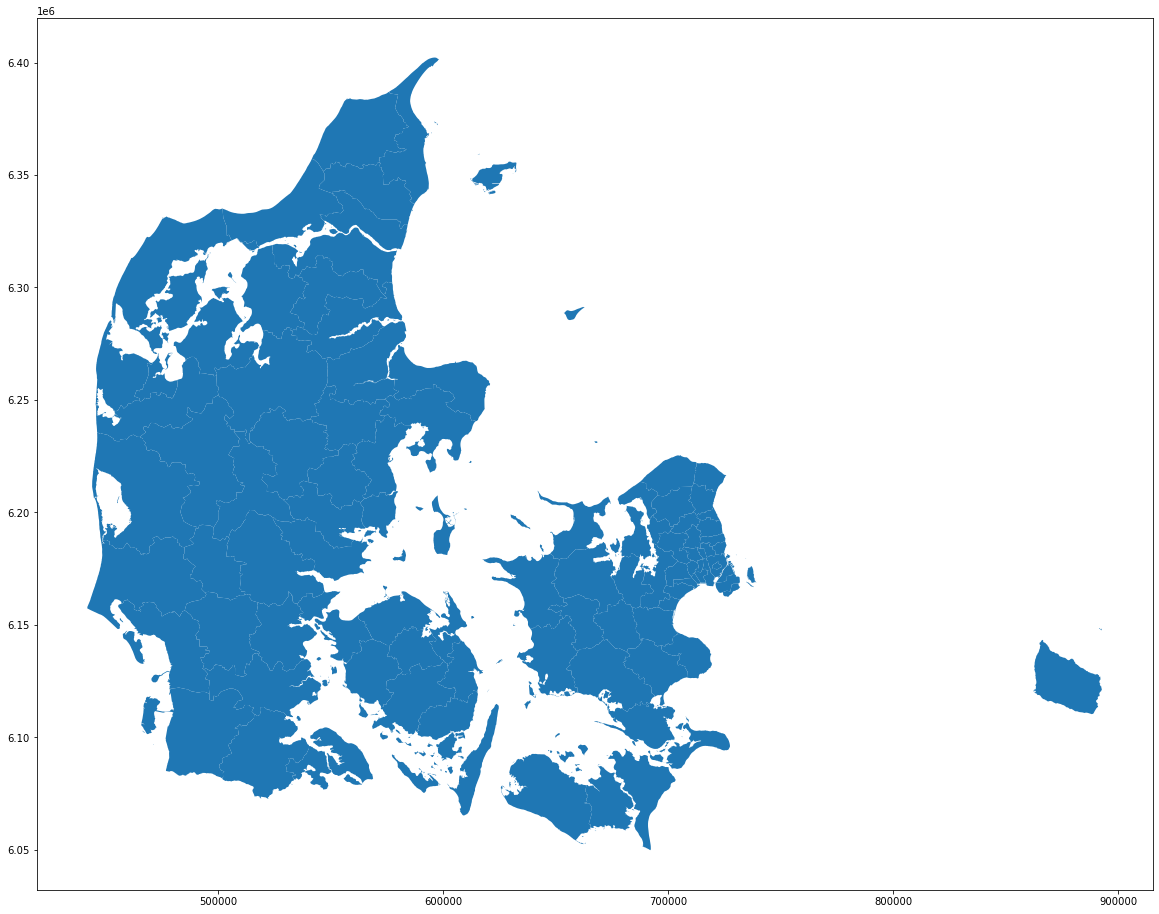

In [147]:
Kort = kommuner.plot(figsize=(20,20))
Kort


Jeg forsøger nu at danne et grid af små områder, til at opdele kortet. 